`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 

В практических примерах ниже показано:   

* как снижать размерность пространства признаков методами главных компонент (PCR), частных наименьшах квадратов (PLS)  
* как строить логистическую регрессию с регуляризацией параметров (методы ридж и лассо) 

Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 
*Данные*: `Wines` (источник: [репозиторий к книге С.Рашки Python и машинное обучение, глава 4](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch04))

# Указания к выполнению


## Загружаем пакеты

In [ ]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# константы
#  ядро для генератора случайных чисел
my_seed = 9212
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [ ]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

### Загружаем данные
fixed_acidity – постоянная кислотность;
volatile_acidity – переменная кислотность;
citric_acid – содержание лимонной кислоты;
residual_sugar – остаточный сахар;
chlorides – содержание хлоридов;
free_sulfur_dioxide – содержание диоксида серы в свободном виде;
total_sulfur_dioxide – общее содержание диоксида серы;
density – плотность;
pH – кислотность;
sulphates – содержание сульфатов;
alcohol – содержание алкоголя;
quality – балльная оценка качества вина, от 0 до 10;
Y – целевая переменная: 1 = высокое качество (quality > 5), 0 = низкое (quality <= 5).

In [ ]:
# загружаем таблицу и превращаем её во фрейм
DF_all = pd.read_csv('https://raw.githubusercontent.com/ania607/ML/main/data/winequality-red_for_lab.csv')

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (1599, 13)


In [ ]:
DF_all = DF_all.drop(["citric_acid", "density", "quality"], axis = 1)
DF_all.head(10)

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,Y
0,7.4,0.70,1.9,0.076,11.0,34.0,3.51,0.56,9.4,0
1,7.8,0.88,2.6,0.098,25.0,67.0,3.20,0.68,9.8,0
2,7.8,0.76,2.3,0.092,15.0,54.0,3.26,0.65,9.8,0
3,11.2,0.28,1.9,0.075,17.0,60.0,3.16,0.58,9.8,1
4,7.4,0.70,1.9,0.076,11.0,34.0,3.51,0.56,9.4,0
5,7.4,0.66,1.8,0.075,13.0,40.0,3.51,0.56,9.4,0
6,7.9,0.60,1.6,0.069,15.0,59.0,3.30,0.46,9.4,0
7,7.3,0.65,1.2,0.065,15.0,21.0,3.39,0.47,10.0,1
8,7.8,0.58,2.0,0.073,9.0,18.0,3.36,0.57,9.5,1
9,7.5,0.50,6.1,0.071,17.0,102.0,3.35,0.80,10.5,0


Отложим 15% наблюдений для прогноза.  

In [ ]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)
# первые 5 строк фрейма у первых 7 столбцов
DF.head(5)

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,Y
117,7.8,0.56,2.0,0.082,7.0,28.0,3.37,0.50,9.4,1
1366,7.3,0.74,1.7,0.094,10.0,45.0,3.24,0.50,9.8,0
329,10.7,0.46,2.0,0.061,7.0,15.0,3.18,0.62,9.5,0
1038,8.7,0.41,6.2,0.078,25.0,42.0,3.24,0.77,12.6,1
1106,8.2,0.23,1.9,0.069,9.0,17.0,3.21,0.54,12.3,1


In [ ]:
# типы столбцов фрейма
DF.dtypes

fixed_acidity           float64
volatile_acidity        float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [ ]:
# считаем пропуски в каждом столбце
DF.isnull().sum()

fixed_acidity           0
volatile_acidity        0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
pH                      0
sulphates               0
alcohol                 0
Y                       0
dtype: int64

Пропусков не обнаружено.  

In [ ]:
DF.count()

fixed_acidity           1359
volatile_acidity        1359
residual_sugar          1359
chlorides               1359
free_sulfur_dioxide     1359
total_sulfur_dioxide    1359
pH                      1359
sulphates               1359
alcohol                 1359
Y                       1359
dtype: int64

И количество записей в нашей таблице одинаковое


# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `target`.  

In [ ]:
# метки классов
DF.Y.unique()

array([1, 0])

In [ ]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

1    0.532
0    0.468
Name: Y, dtype: float64

Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.  

In [ ]:
# описательные статистики
DF.iloc[:, :6].describe()

,fixed_acidity,volatile_acidity,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.337013,0.527792,2.554746,0.087676,15.866078,46.738779
std,1.756618,0.177531,1.450287,0.048260,10.634496,33.416700
min,4.600000,0.120000,0.900000,0.012000,1.000000,6.000000
25%,7.100000,0.392500,1.900000,0.070000,7.000000,22.000000
50%,7.900000,0.520000,2.200000,0.079000,13.000000,38.000000
75%,9.200000,0.640000,2.600000,0.090000,21.000000,63.000000
max,15.900000,1.580000,15.500000,0.611000,72.000000,289.000000


In [ ]:
# описательные статистики
DF.iloc[:, 6:11].describe()

,pH,sulphates,alcohol,Y
count,1359.000000,1359.000000,1359.000000,1359.000000
mean,3.308219,0.658661,10.403557,0.532009
std,0.153734,0.172279,1.067067,0.499158
min,2.740000,0.330000,8.400000,0.000000
25%,3.210000,0.550000,9.500000,0.000000
50%,3.310000,0.620000,10.100000,1.000000
75%,3.400000,0.730000,11.033333,1.000000
max,4.010000,2.000000,14.900000,1.000000


Выводы по описательным статистикам: значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 9 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

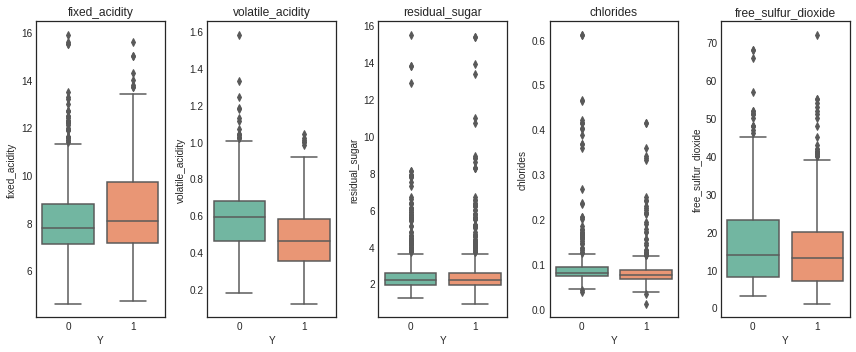

In [ ]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

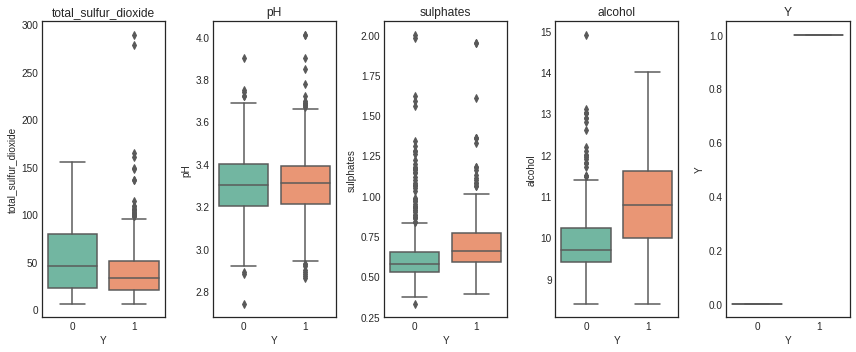

In [ ]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается практически по всем объясняющим переменным. Меньше всего различаются коробчатые диаграммы по переменным pH и residual_sugar. Это говорит о том, классы по зависимой переменной Y неплохо разделяются по всем объясняющим переменным.

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

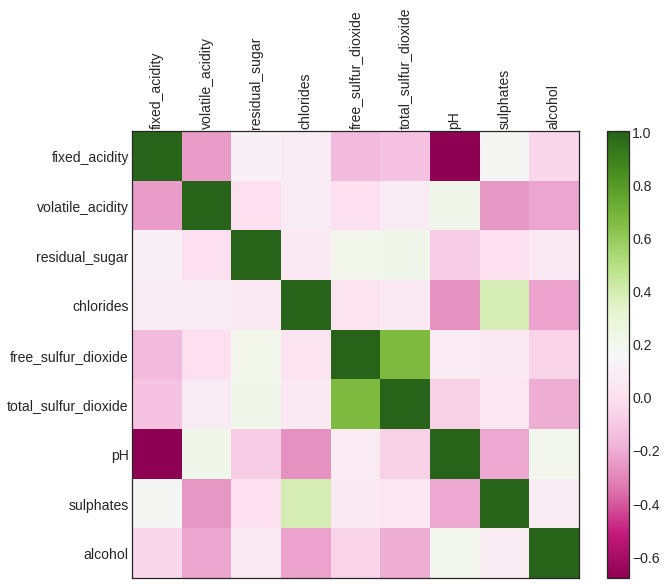

In [ ]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [ ]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
5,fixed_acidity,pH,-0.680575,0.0
23,chlorides,pH,-0.271395,0.0
13,volatile_acidity,sulphates,-0.255494,0.0
0,fixed_acidity,volatile_acidity,-0.242167,0.0
25,chlorides,alcohol,-0.225534,0.0
14,volatile_acidity,alcohol,-0.217178,0.0
33,pH,sulphates,-0.210718,0.0
32,total_sulfur_dioxide,alcohol,-0.196372,0.0
3,fixed_acidity,free_sulfur_dioxide,-0.159035,0.0
4,fixed_acidity,total_sulfur_dioxide,-0.116626,0.0


# Методы снижения резмерности  
 

* регрессия на главные компоненты (PCR)   



In [ ]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :10].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = -0.0   Станд. отклонение = 1.0
Столбец 1: среднее = -0.0   Станд. отклонение = 1.0
Столбец 2: среднее = -0.0   Станд. отклонение = 1.0
Столбец 3: среднее = 0.0   Станд. отклонение = 1.0
Столбец 4: среднее = 0.0   Станд. отклонение = 1.0
Столбец 5: среднее = 0.0   Станд. отклонение = 1.0
Столбец 6: среднее = -0.0   Станд. отклонение = 1.0
Столбец 7: среднее = -0.0   Станд. отклонение = 1.0
Столбец 8: среднее = -0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0


## Регрессия на главные компоненты (PCR)


Пересчитаем объясняющие показатели в главные компоненты.

In [ ]:
# функция с методом главных компонент
pca = PCA()
# пересчитываем в главные компоненты (ГК)
X_train_pca = pca.fit_transform(X_train_std)

# считаем доли объяснённой дисперсии
frac_var_expl = pca.explained_variance_ratio_
print('Доли объяснённой дисперсии по компонентам в PCR:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PCR:
 [0.215 0.199 0.158 0.116 0.091 0.063 0.054 0.047 0.033 0.024] 
Общая сумма долей: 1.0


Главные компоненты взаимно ортогональны, убедимся в этом.

In [ ]:
# ГК ортогональны – убедимся в этом, рассчитыв корреляционную матрицу
corr_mat = pd.DataFrame(X_train_pca).corr()
np.around(corr_mat, 2)

,0,1,2,3,4,5,6,7,8,9
0,1.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
1,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
2,0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0
3,-0.0,-0.0,-0.0,1.0,0.0,-0.0,0.0,-0.0,0.0,0.0
4,-0.0,-0.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,0.0,-0.0
5,-0.0,0.0,0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,-0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0
7,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,-0.0,-0.0
8,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,1.0,-0.0
9,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0


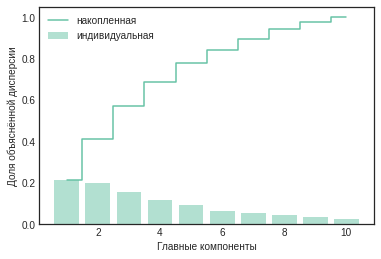

In [ ]:
# график объяснённой дисперсии
plt.bar(range(1,11),frac_var_expl,alpha=0.5,align='center',label='индивидуальная')
plt.step(range(1,11),np.cumsum(frac_var_expl),where='mid',label='накопленная')
plt.ylabel('Доля объяснённой дисперсии')
plt.xlabel('Главные компоненты')
plt.legend()
plt.show()

Столбцы на графике показывают долю исходной дисперсии исходных переменных, которую объясняет главная компонента. Линией показана накопленная доля. Так, видно, что первые 5 компонент объясняют 80% исходной дисперсии .
Чтобы увидеть, как классы выглядят в координатах ГК на графике, придётся сократить пространство для двух компонент, которые объясняют примерно 40% разброса объясняющих переменных.

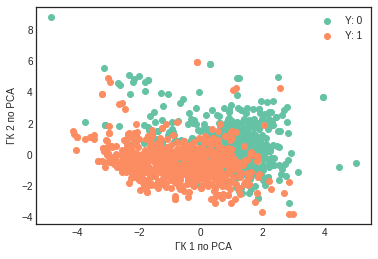

In [ ]:
# пересчитываем X в 2 ГК
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)

# график классов в пространстве ГК
plt.scatter(X_train_pca[DF['Y'] == 0][:, 0], 
            X_train_pca[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pca[DF['Y'] == 1][:, 0], 
            X_train_pca[DF['Y'] == 1][:, 1], label='Y: 1')

plt.xlabel('ГК 1 по PCA')
plt.ylabel('ГК 2 по PCA')
plt.legend()
plt.show()

Судя по графику, классы средне разделяются в пространстве двух главных компонент. Построим логистическую регрессию и оценим её точность с помощью перекрёстной проверки.

In [ ]:
# функция оценки логистической регрессии
logit = LogisticRegression()
# функция разбиения на блоки для перекрёстной проверки
kf_10 = KFold(n_splits=10, random_state=my_seed, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
score = list()
acc = cross_val_score(logit, X_train_pca, DF.Y.values, cv=kf_10,
                     scoring='accuracy').mean()
score.append(np.around(acc, 3))
score_models = list()
score_models.append('logit_PC2')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PC2, перекрёстная проверка по 10 блокам
Acc = 0.8


# Методы сжатия  




## Ридж-регрессия

Построим ридж на наших данных.  

In [ ]:
Y_train = DF.Y.values
# функция для построения модели
logit_ridge = LogisticRegression(penalty='l2', solver='liblinear')
# оцениваем параметры
logit_ridge.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_ridge.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_ridge.coef_, 3))

Константы моделей для классов:
 [0.372] 
Коэффициенты моделей для классов:
 [[ 0.024 -0.212  0.006 -0.096  0.056 -0.219 -0.011  0.185  0.349  5.337]]


Подбираем гиперпараметр регуляризации  с помощью перекрёстной проверки. В функции LogisticRegression() есть аргумент лямбда – это инверсия гиперпараметра .

In [ ]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
ridge_cv = LogisticRegressionCV(cv=10, random_state=my_seed+2, 
                                penalty='l2', solver='liblinear')
ridge_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
ridge_cv.C_

array([0.04641589])

In [ ]:
# сохраняем и выводим Acc для модели
score.append(np.around(ridge_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_ridge')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_ridge, перекрёстная проверка по 10 блокам
Acc = 1.0


Изобразим изменение коэффициентов ридж-регрессии на графике и сделаем отсечку на уровне оптимального параметра С

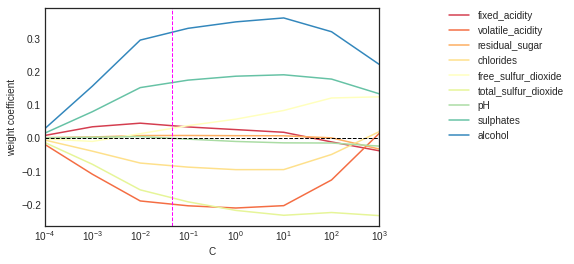

In [ ]:
# график динамики коэффициентов в ридж-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l2', ridge_cv.C_, DF.columns)

Итак, судя по графикам, для значения гиперпараметра, дающего самую точную модель, ни один коэффициент при объясняющих переменных не обнуляется.


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [ ]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})


,Модель,Acc
0,logit_PC2,0.795
1,logit_ridge,1.000


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается ридж-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [ ]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :10].values)
Y_pred = DF_predict.Y
Y_hat = logit_ridge.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      1.00      1.00       132

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



Итак, методом логистической регрессии со сжатием коэффициенты с L2-регуляризацией мы получили идеально точную модель классификации трёх видов красных вин.

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

